In [1]:
from time import sleep, time
from math import sin, cos, tan, pi
import pandas as pd 
import math
import matplotlib.pyplot as plt
import numpy as np
from rotations import Quaternion, skew_symmetric

In [2]:
data = pd.read_csv('imu_data.csv')
len(data)

2000

In [3]:
#initialization angles
ax = data.Ax[0]
ay = data.Ay[0]
az = data.Az[0]
ax_i = math.atan2(ax, math.sqrt(ax ** 2.0 + az ** 2.0))
ay_i = math.atan2(ay, math.sqrt(ay ** 2.0 + az ** 2.0))
az_i = math.atan2(az, math.sqrt(ay ** 2.0 + ax ** 2.0))

In [4]:
print(ax_i,ay_i,az_i)

0.11882867542217958 0.032278251114209545 1.446918579664333


In [5]:
data.head()

,t,Ax,Ay,Az,Gx,Gy,Gz
0,0.000000,0.098145,0.026367,0.816162,-0.679389,1.076336,-1.152672
1,0.000197,0.101562,0.030762,0.815186,-3.007634,1.854962,0.114504
2,0.019354,0.106201,0.028809,0.838867,-6.396947,2.618321,0.572519
3,0.037792,0.104004,0.042969,0.843750,-12.022901,3.877863,1.351145
4,0.056218,0.079590,0.013672,0.841797,-6.931298,3.267176,-0.099237


In [6]:
T = data.t[0:1000]

In [7]:

#Number of Iterations
timesteps = 1000
# Filter coefficient
alpha = 0.1

#Gyroscope Bias
biasx = 0.0
biasy = 0.0
biasz = 0.0

# Complimentary filter Output
phi_hat = 0.0
theta_hat = 0.0
shi_hat = 0.0

#For angles 
phi_hat = [ax_i]
theta_hat = [ay_i]
shi_hat = [az_i]

q_est = np.zeros([timesteps, 4])  # orientation estimates as quaternions
q_est[0] = Quaternion(axis_angle = [ax_i,ay_i,az_i]).to_numpy()

gtx = [ax_i]
gty = [ay_i]
gtz = [az_i]

atx = [ax_i]
aty = [ay_i]
atz = [az_i]
q_est[0]

array([0.74778659, 0.05432985, 0.01475799, 0.66154795])

In [8]:
for i in range(1,timesteps):
    
     # Raw accelerometer data to meaningful Data 
    ax = data.Ax[i]
    ay = data.Ay[i]
    az = data.Az[i]
    phi_hat_acc = math.atan2(ax, math.sqrt(ax ** 2.0 + az ** 2.0))
    theta_hat_acc = math.atan2(ay, math.sqrt(ay ** 2.0 + az ** 2.0))
    shi_hat_acc = math.atan2(az, math.sqrt(ay ** 2.0 + ax ** 2.0))
    
    # Get raw gyro data and subtract biases
    
    x = data.Gx[i] * math.pi*(data.t[i]-data.t[i-1])/ (180.0)
    y = data.Gy[i] * math.pi*(data.t[i]-data.t[i-1]) / (180.0)
    z = data.Gz[i] * math.pi*(data.t[i]-data.t[i-1]) / (180.0)
    x -= biasx
    y -= biasy
    z -= biasz
    
    # Calculate Euler angle derivatives 
    q_check = Quaternion(axis_angle = ([x,y,z])).quat_mult(q_est[i-1]) 
    
    
    #Store Values only from accelerometer
    temp = Quaternion(*q_check).to_euler()
    gtx.append(temp[0])
    gty.append(temp[1])
    gtz.append(temp[2])
    
    #Store Values only from accelerometer
    atx.append(phi_hat_acc)
    aty.append(theta_hat_acc)
    atz.append(shi_hat_acc)
    
    # Complimentary filter update
    phi_hat.append((1 - alpha)*(gtx[i]) + alpha * phi_hat_acc)
    theta_hat.append((1 - alpha)*(gty[i]) + alpha * theta_hat_acc)
    shi_hat.append((1 - alpha)*(gtz[i]) + alpha * shi_hat_acc)
    q_est[i] = Quaternion(euler = [phi_hat[i],theta_hat[i],shi_hat[i]]).to_numpy()
    
    # Display results
    #print("Phi: " + str(round(phi_hat[i] * 180.0 / pi, 1)) + " | Theta: " + str(round(theta_hat[i] * 180.0 / pi, 1)))

Text(0.5, 1.0, 'X-orientation')

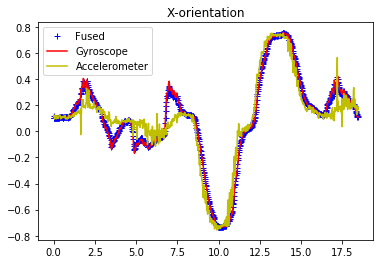

In [9]:
fig, ax = plt.subplots()
ax.plot(T,phi_hat, '+b', label='Fused')
ax.plot(T,gtx, 'r', label='Gyroscope')
ax.plot(T,atx, 'y', label='Accelerometer')
leg = ax.legend();
plt.title('X-orientation')

Text(0.5, 1.0, 'Y-orientation')

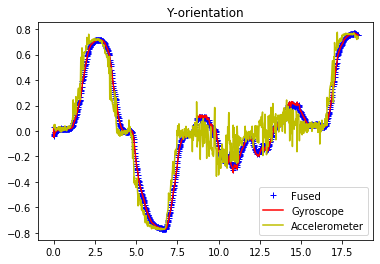

In [10]:
fig, ax = plt.subplots()
ax.plot(T,theta_hat, '+b', label='Fused')
ax.plot(T,gty, 'r', label='Gyroscope')
ax.plot(T,aty, 'y', label='Accelerometer')
leg = ax.legend();
plt.title('Y-orientation')

Text(0.5, 1.0, 'Z-orientation')

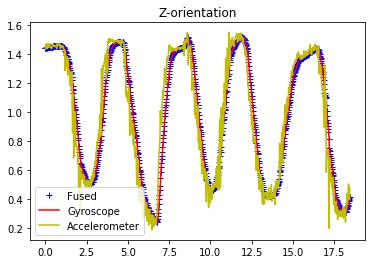

In [11]:
fig, ax = plt.subplots()
ax.plot(T,shi_hat, '+b', label='Fused')
ax.plot(T,gtz, 'r', label='Gyroscope')
ax.plot(T,atz, 'y', label='Accelerometer')
leg = ax.legend();
plt.title('Z-orientation')